# 深圳市出租车GPS数据分析

In [29]:
# 导入所有需要的包
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

## 1 出租车GPS数据读取与清洗

### 1.1 数据读取

该数据为深圳市一天时间内抽样500辆出租车的GPS数据，字段包括：车辆ID、经度、纬度、时间、载客状态与速度。

In [30]:
# 读取GPS数据文件，传入参数header避免第一行数据变成表格列名
data = pd.read_csv('./assets/data/TaxiData-Sample.csv', header=None)
# 由于数据没有列名，手动设置数据的列名为["车牌号", "时间", "经度", "纬度", "载客状态", "车速"]
data.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']
data

,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed
0,34745,20:27:43,113.806847,22.623249,1,27
1,34745,20:24:07,113.809898,22.627399,0,0
2,34745,20:24:27,113.809898,22.627399,0,0
3,34745,20:22:07,113.811348,22.628067,0,0
4,34745,20:10:06,113.819885,22.647800,0,54
...,...,...,...,...,...,...
544994,28265,21:35:13,114.321503,22.709499,0,18
544995,28265,09:08:02,114.322701,22.681700,0,0
544996,28265,09:14:31,114.336700,22.690100,0,0
544997,28265,21:19:12,114.352600,22.728399,0,0


### 1.2 清洗异常数据

时空大数据中不存在完美的数据，任何数据都存在异常。

#### 1.2.1 载客状态字段异常

数据中的载客状态 `OpenStatus` 字段表征了出租车载客状态。当值为 `1` 时，表示出租车有乘客，为载客状态；反之则为空载状态。如果将所有的车辆数据读取在一个表中，将数据按车牌号和时间排序，那么在理想状态下，一辆出租车正常的 `OpenStatus` 序列应该连续 `0` 序列和连续 `1` 序列依次出现。

当 `OpenStatus` 的值由 `A` 时刻的 `0` 变为 `B` 时刻的 `1` 时，代表乘客在 `A` 时刻与 `B` 时刻中间的某一时刻上车，运营开始。同样，当 `OpenStatus` 的值由 `C` 时刻的 `1` 变为 `D` 时刻的 `0` 时，代表乘客在 `C` 时刻与 `D` 时刻中间的某一时刻下车，运营结束。由于出租车的采样频率约为 `15s` 一次，可以近似地认为相邻采样点在时间和空间上十分相近， `A` 、 `B` 两个时刻都可以看成乘客的上车点；同样地， `C` 时刻和 `D` 时刻都可以看成下车点。为了数据处理的方便，统一把 `A` 时刻看成乘客的上车点， `C` 时刻看成乘客的下车点。

但是 `OpenStatus` 字段中可能会出现异常情况：

- 在连续 `0` 的序列中，突然出现一个 `1` 。如果用刚才判断乘客上下车处理逻辑，异常数据会导致乘客上下车点连续的两条记录，如果没有剔除，后续的出行OD分析中则会表现为在同一地点上下车。
- 在连续 `1` 的序列中，突然出现一个 `0` 。不排除某些出租车司机生意火爆，上一个订单结束后来不及休息就可以马不停蹄地开始下一单。但考虑到GPS数据 `15s` 的采样间隔，要在 `15~30s` 的时间内实现一个乘客付钱、下车，另一个乘客上车、关上车门、开始打表的一系列过程，对两个乘客来说可能是难度系数较高的操作，可以认为这是一种小概率事件。

这两种情况的产生都极有可能是采集设备的突发异常造成的，在数据清洗中，应将这两种情况都予以剔除。

#### 1.2.2 数据清洗思路

如何剔除上面提到的两种数据异常呢？我们可以很容易地说出这两种异常都具有的共同特征：

- 异常数据的载客状态与前一条数据和后一条数据的值均不同。
- 这三条数据必须是同一辆出租车的连续数据。

也就是，程序只需要找到符合上述特征的数据，并将其剔除即可。如果将上面的条件总结成为程序中判断条件，则为：

- 异常数据的 `OpenStatus` 与前一条数据不等。
- 异常数据的 `OpenStatus` 与后一条数据不等。
- 异常数据的 `VehicleNum` 与前一条数据的 `VehicleNum` 相等。
- 异常数据的 `VehicleNum` 与后一条数据的 `VehicleNum` 相等。

将上面的这四个条件用 `&` 连接起来，所判断的即为异常数据，而将异常数据剔除，就完成了清洗。

#### 1.2.3 数据排序与异常数据剔除

In [31]:
# 对数据按照车牌与GPS时间进行排序，让同一辆车的数据放在一起，且按照时间大小排序。
data = data.sort_values(by=['VehicleNum', 'Stime'])
# 将数据的前一行和后一行的信息都放在了同一行上，以两个新的字段表示，用于判断。
# 将OpenStatus列整体下移一行，赋值给OpenStatus1列
data['OpenStatus1'] = data['OpenStatus'].shift()
# 将OpenStatus列整体上移一行，赋值给OpenStatus2列
data['OpenStatus2'] = data['OpenStatus'].shift(-1)
# 将VehicleNum列整体下移一行，赋值给VehicleNum1列
data['VehicleNum1'] = data['VehicleNum'].shift()
# 将VehicleNum列整体下移一行，赋值给VehicleNum2列
data['VehicleNum2'] = data['VehicleNum'].shift(-1)
# 剔除异常数据
data = data[-((data['OpenStatus'] != data['OpenStatus1']) &  # 条件一
              (data['OpenStatus'] != data['OpenStatus2']) &  # 条件二
              (data['VehicleNum'] == data['VehicleNum1']) &  # 条件三
              (data['VehicleNum'] == data['VehicleNum2']))]  # 条件四
# 删除辅助判断的列，用axis=1指定使用列名删除
data = data.drop(['OpenStatus1', 'OpenStatus2', 'VehicleNum1', 'VehicleNum2'],
                 axis=1)
# 结果保存，保存数据到指定路径，index关键字决定是否保存行名
data.to_csv('./assets/data/TaxiData-Clean.csv', index=None,
            encoding='utf-8_sig')
data

,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed
20280,22396,00:00:29,113.996719,22.693333,1,20
19577,22396,00:01:01,113.995514,22.695032,1,34
19985,22396,00:01:09,113.995430,22.695766,1,41
19153,22396,00:01:41,113.995369,22.696484,1,0
19986,22396,00:02:21,113.995430,22.696650,1,17
...,...,...,...,...,...,...
177680,36805,23:53:21,114.120354,22.544300,1,0
182105,36805,23:53:27,114.120354,22.544300,1,0
178293,36805,23:53:33,114.120354,22.544300,1,0
177982,36805,23:53:36,114.120354,22.544300,0,0


## 2 出租车数据的时空完整性评估

### 2.1 如何评估数据质量

可以从数据的基本特征、数据的完整性和准确性等方面初步评估手中的数据质量：

1. **数据的基本特征**。对数据基本特征的分析，应关注数据能够反映样本的什么特征。例如，对于出租车数据，首先需要关注的是GPS设备的采样频率。不同采样频率的数据，能够做的事情是不同的，例如，目前手上的数据采样频率约为 `15s` 一条，此时可以分析出行的OD信息、车辆的运行速度、交叉口的延误等；如果采样粒度更精细， `1s` 一条，那么可以用来分析车辆的运行工况、加减速等；反之，如果采样粒度粗糙， `1 ~ 2h` 一条，那么可能只能用来分析车辆大致的分布、出行的热点分布。
2. **数据的完整性**。对数据的完整性，首先观察数据本身的内容是否存在缺失值。在出租车数据中，需要检查每一条出租车数据是否有经纬度、时间、运营状态等，不存在缺失值。如果存在缺失值，数据的缺失率是多少？能否补全数据，如何补全？删除缺失数据是否会影响分析结果？对时空大数据，数据的完整性还得考虑个体、时间与空间维度。在个体维度上，需要回答：数据是抽样数据还是全样本数据？如果是抽样数据，数据量是多少？怎么抽样？抽样率是多少？抽样数据在时空上有什么特征？数据是城市中一家出租车运营公司的数据还是所有出租车运营公司的数据总和？在时间维度上，数据是否在某段时间内存在缺失？这种缺失是因为数据采集出现问题，还是数据本身在这一时段内就比较少？在空间维度上，数据是否在某个地理域范围内存在缺失？是这里本身就处于郊区没采集到样本，还是这里的GPS信号因为某种故障而丢失？
3. **数据的准确性**。数据的准确性则是评估数据与真实情况的差异。例如，某市的出租车数据经纬度是否在该市的地理范围内？如果超出该市的地理范围，超出距离大概是多少？更细来说，出租车应该出现在道路上，不可能出现在建筑物里，那么数据能否很准确地分布在道路上？数据的地理位置是否存在瞬移？出租车的车速是否在合理范围，若车速为负值或者超出城市运营管理速度的上限，那就有理由怀疑这些速度的准确性。

### 2.2 出租车数据的时间完整性评估

本节以出租车数据的时间维度完整性为例进行质量评估，统计数据在时间上的分布情况。数据的时间统计粒度不同，会导致最后统计的结果出现一定差异。因此，需要根据研究目的，确定与其相适应的时间统计单位。在本节中，将以小时为粒度，统计出租车GPS数据与出行订单数量的小时分布情况。

时空大数据的时间信息可能包括年、月、日、时、分、秒等时间单位，而在读取数据时，如果没有设定时间格式，读取进来的时间字段的值将以字符串形式呈现，我们手中数据的时间格式与统计粒度并不能够完全重合。因此，如果需要统计每小时出租车的GPS数据量与出行订单数量，需要从时间字段中提取出小时的信息，作为数据表中的一列，并将以此列为依据进行统计。

因此，这里的核心工作是如何从时间字段中提取出小时信息以及如何基于小时信息统计每小时的数据量。

#### 2.2.1 时间字段的处理

把 `Series` 对象转换为 `pandas` 内置的 `StringMethods` 对象，并使用 `StringMethods` 对象的 `slice` 方法截取字符串切片，传入开始与结束位置的索引，提取前两位字符，从而获取小时信息。

采用 `StringMethods` 对象的方法，可以对原有 `Series` 的每一行进行相同的字符串操作，输出结果为 `Series` 形式。其中的过程可以理解为 `StringMethods` 对象的方法对原 `Series` 的每一行元素遍历操作，将所有行的结果按照原有 `Series` 的 `Index` 排序，构成一个 `Series` 后输出。

In [32]:
# 把Stime列转化为StringMethods对象，进行切片操作，在赋值给Hour列
data['Hour'] = data['Stime'].str.slice(0, 2)
# 提取出的结果为字符串类型，需要转换为数值型
data['Hour'] = data['Hour'].astype(int)
data

,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed,Hour
20280,22396,00:00:29,113.996719,22.693333,1,20,0
19577,22396,00:01:01,113.995514,22.695032,1,34,0
19985,22396,00:01:09,113.995430,22.695766,1,41,0
19153,22396,00:01:41,113.995369,22.696484,1,0,0
19986,22396,00:02:21,113.995430,22.696650,1,17,0
...,...,...,...,...,...,...,...
177680,36805,23:53:21,114.120354,22.544300,1,0,23
182105,36805,23:53:27,114.120354,22.544300,1,0,23
178293,36805,23:53:33,114.120354,22.544300,1,0,23
177982,36805,23:53:36,114.120354,22.544300,0,0,23


#### 2.2.2 数据量的小时统计

接下来，如何基于小时信息统计每小时的数据量？通过前面时间字段中的小时信息的提取，同一小时内产生的GPS数据， `Hour` 字段中会拥有相同的值，可以依据这一字段对数据采用 `groupby` 方法进行集计操作，再用 `count` 方法指定 `VehicleNum` 列统计每小时的数据量。

In [33]:
# 分组并统计各组数量
Hourcount = data.groupby('Hour')['VehicleNum'].count()
# 更改Series的列名，并将通过reset_index将Series变成DataFrame
Hourcount = Hourcount.rename('count').reset_index()
Hourcount

,Hour,count
0,0,23701
1,1,22312
2,2,21235
3,3,20019
4,4,19682
5,5,20068
6,6,19533
7,7,22388
8,8,23789
9,9,22001


#### 2.2.3 数据量时间分布图绘制

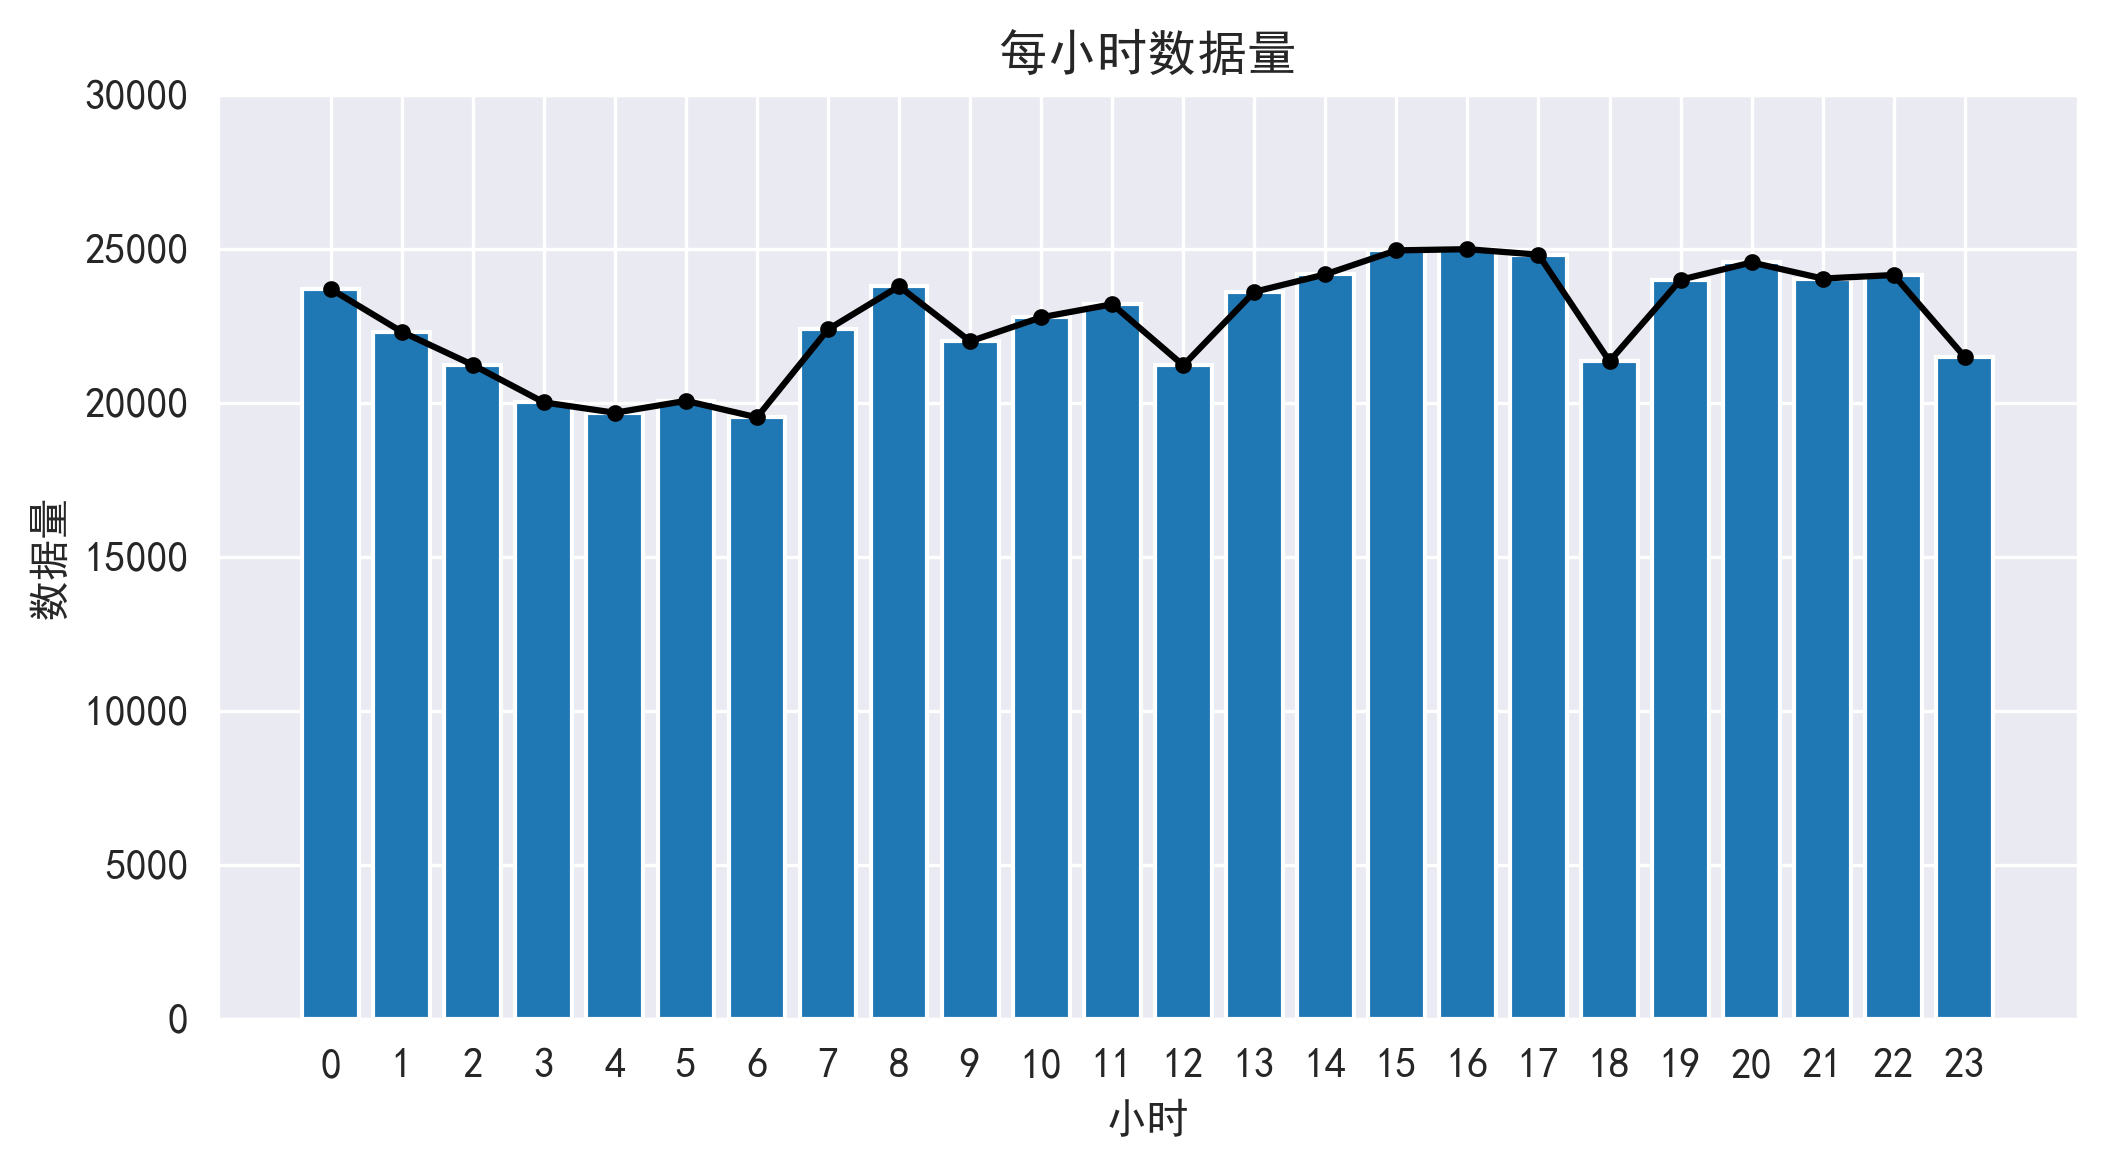

In [34]:
# 创建一个图,图的尺寸为8×4,dpi为300
fig = plt.figure(1, (8, 4), dpi=300)
# 在图中创建子图
# 111分别表示：创建共一个子图，子图的布局为1行1列
ax = plt.subplot(111)
# 绘制折线图，线为黑色实线
plt.plot(Hourcount['Hour'], Hourcount['count'], 'k-')
# 绘制散点图，每个数据点为黑色
plt.plot(Hourcount['Hour'], Hourcount['count'], 'k.')
# 绘制柱状图
plt.bar(Hourcount['Hour'], Hourcount['count'])
# 加y轴标题
plt.ylabel('数据量')
# 加x轴标题
plt.xlabel('小时')
# 调整x轴标签
plt.xticks(range(24), range(24))
# 加图标题
plt.title('每小时数据量')
# 设置y轴范围
plt.ylim(0, 30000)
# 显示图
plt.show()

### 2.3 出租车数据的空间完整性评估

数据空间分布可视化方法有如下几种：

1. **栅格或散点图**。以栅格形式表达数据分布是最基本的表达方法。GPS数据经过栅格化后，每个数据点都含有对应的栅格信息，采用栅格表达数据的分布时，其表示的分布情况与真实情况最接近。栅格与散点图的原理相同，只是统计的空间单元大小不同。通过栅格统计数据时，随着栅格内点数据量的增加，栅格聚集性的值增加，空间点的作用范围限制在提前划分好的栅格内，相邻栅格的聚集性互不影响。栅格与栅格之间的空间聚集性差异性可能很大，数据不平滑。
2. **小区**。这种方式是把数据统计到交通小区，统计每个交通小区的数据量，并以颜色深浅表示。由于交通小区的划分在城市核心区域密度大，分区小；而在城市外围郊区，交通小区密度小，分区较大。在经过集计后，在面积较大的交通小区数据量会被稀释，导致结果失真。
3. **核密度估计**。在采用核密度估计表示数据分布时，每个数据点存在一定规则的影响范围，影响程度从内向外逐渐减少，形成了以点为中心影响渐变带。因此，空间某一位置的数据疏密程度为其相邻点影响叠加，在可视化中可以达到平滑数据的效果。也正是因为如此，平滑数据的处理可能会无法准确反映数据在空间的聚集情况，不能保证数据分布的准确性。另外还需要注意的是，在对核密度进行可视化时，不同的颜色分类间隔会产生不同的视觉效果。
4. **热力图**。热力图可视化的效果与核密度估计相近，但原理不同。与核密度估计相比，热力图避免了对空间每个点都计算概率密度，而是采用颜色的简单叠加效果以减少计算量。热力图可视化所需的计算量较小，显示效率高，目前广泛应用于网页可视化中。

#### 2.3.1 出租车GPS数据空间分布栅格图

出租车数据GPS的定位精度达到小数点后 `6` 位，即便两条记录发生在非常接近的地点，产生的经纬度坐标也只有极小的概率相同。如果直接采用经纬度坐标进行空间集计，则无法达到数据聚合的效果，在所有位置统计出来的点数量都是 `1` 。因此，要评估数据的空间完整性，首先需要对数据以特定地理空间统计单元进行统计。

我们可以使用栅格化方法，利用该方法能够将研究区域划分为等长宽的正方形栅格，也能够经过简单的数学运算将数据点与其所在的栅格进行对应。在这一节中将用代码实现栅格化，对研究范围生成栅格，并对出租车的空间信息进行集计处理。

那么什么是栅格化方法呢？

**为什么数据需要栅格化？**

栅格数据在空间分析方面具有矢量数据无法比拟的优势：栅格空间数据的叠置和组合更方便，利用栅格数据更容易进行各类空间分析。

怎么理解呢？想象一个韦恩图一样的区域，假设在研究范围内用矢量图形划分了蓝色和红色两个区域。我们输入的矢量数据只有两个，把地理空间切分成了 `4` 个分区：蓝色区域、红色区域、红蓝重叠区域和红蓝都不覆盖的区域。矢量越多，重叠的层数越多，每次一叠加就要对矢量图形切分，划分出大量不规则的矢量图形。这些矢量图形形状不同，面积也不同，因此，它们所带的属性很难进行比较。例如，区域 `1` 中有 `10` 人，区域 `2` 中有 `20` 人，可以说区域 `1` 人数比区域 `2` 少。但这两个区域可能不一样大，区域 `1` 面积为 `10m^2` ，区域 `2` 面积为 `30m^2` ，那么我们得计算它们的人口密度进行比较，得到区域 `1` 密度比区域 `2` 大。再然后，还要考虑到这两个区内人口集中程度可能不同，在区域 `2` 中可能大部分地方都没人，人口集中在小范围的密度大的区域内，而区域 `1` 人口分布就比较均匀，整体的密度都不大。在这个过程中，虽然能够确保分析过程中空间位置的精确性，但我们在空间上的最小分析单元是不规则的，也就加大了分析的难度。

如果以栅格的方式来分析，可以把整个研究区域划分为大量栅格，上述划分的 `4` 个区域都可以用细小的栅格构成。如果再叠加矢量图形上去，只需要再判断栅格与矢量图形的空间关系即可。由于栅格和矢量都有一定面积，在边界处可能会出现一个栅格横跨了多个矢量面，我们通常以栅格中心点所在位置来判断栅格属于哪个矢量面。此时，空间上最小分析单元是栅格，我们能够确保每个栅格的形状、大小都相同，它们的属性也能够更加方便地进行比较。

这样的分析模式虽然会造成一定的精度下降，但通过控制栅格的大小，可以使这种精度损失降低。例如，可以在研究区域划分 `1000m x 1000m` 、 `100m x 100m` 甚至 `10m x 10m` 的栅格（目前最好的GPS定位精度可以达到 `3 ~ 5m` ，划分栅格时应尽量保证 `10m x 10m` 以上）来实现更精细的空间数据分析。

然而 `GeoPandas` 中处理的地理空间数据都是矢量数据，它并不支持直接对栅格数据进行处理，怎么才能利用到栅格数据的优势呢？

答案是，以矢量数据形式存储栅格数据。栅格本质上就是一个一个有面积的小格子，我们把这些小格子变成一个一个的矢量图形，就可以在 `GeoPandas` 中处理了。

那么，首先就需要对研究范围创建栅格，我们将这个步骤称为栅格化，在ArcGIS中叫做“创建渔网”或“网格化”，创建出来的栅格英文称为Grid、Cell、Fishnet等。需要注意的是，这里的栅格实质上是矢量图形，与栅格数据形式有一定区别。

**栅格化的基本原理是什么呢？**

如何进行栅格化呢？在进行栅格化时，需要考虑的有以下两个问题：

1. 给定研究范围以及栅格大小，如何生成研究范围内所有栅格的地理信息几何图形？对第一个问题，给定研究范围以及栅格大小，栅格化即是对整个研究范围铺满栅格，而要以矢量图形来存储栅格数据，则需要推算出整个研究范围内所有栅格的四个顶点坐标。有了每个栅格的顶点坐标后，就可以构建出每个栅格的几何图形 `Polygon` ，存放到同一个 `GeoDataFrame` 中。
2. 如何将手中的GPS数据以最小的计算量、以最快的方式对应到栅格上？对第二个问题，我们拿到的GPS数据一般是以经纬度形式存储，且经常会遇到百万以上的数量级。如果对每个GPS数据点都需要用复杂的空间连接匹配到栅格上，则需要耗费大量的时间。

综合以上两点，栅格方法的思路即是直接对经纬度进行加减乘除运算。对第一个问题，给定研究范围与栅格大小，推算出栅格的长与宽对应的经度$\Delta\text{lon}$和纬度$\Delta\text{lat}$，再通过每个栅格的编号推算出四个顶点坐标。对第二个问题，则只需要通过简单的加减乘除即可将GPS经纬度对应到栅格，在Python中可以用向量运算解决。相比空间连接匹配，这种向量计算的方法能够极大地提高GPS对应栅格的效率。

**具体怎么栅格化呢？**

**解决第一个问题**，首先以研究范围中心点所在位置为基准，近似的计算每个栅格对应的经纬度$\Delta\text{lon}$和$\Delta\text{lat}$的大小。如果将地球看成一个球，所有的经线周长都相同，而纬线的周长则在赤道时最长（此时与经线一样长），越往两极去，纬线的周长越小。也就是说，除非研究范围在赤道上，否则研究范围内栅格的$\Delta\text{lon}$和$\Delta\text{lat}$是不等的。假设地球半径为 `R` ，研究范围左下角经纬度为$(\text{lon}_1, \text{lat}_1)$，右上角坐标为$(\text{lon}_2, \text{lat}_2)$，则中心点的坐标为$(\text{lon}, \text{lat})=(\frac{\text{lon}_1+\text{lon}_2}{2}, \frac{\text{lat}_1+\text{lat}_2}{2})$。在研究范围处，经线的周长为 `2πR` ，对应经度的 `360°` ；纬线的周长则为 `2πRcos(lat)` ，对应纬度的 `360°` 。那么如果栅格长度为 `a` ，对应的经纬度是多少呢？

$$
\Delta\text{lon}=\frac{a}{2\pi R}*360°
$$

$$
\Delta\text{lat}=\frac{a}{2\pi R\cos(\frac{\text{lat}_1+\text{lat}_2}{2})}*360°
$$

以研究范围的左下角为起点，作为第一个栅格的中心点，把栅格铺满整个研究范围。我们以列号与行号 `(loncol, latcol)` 对栅格进行编号，分别从 `0` 开始（注意，行列号方向为正常的 `xy` 坐标系）。那么给定行号列号，每个栅格的中心点坐标 `(hblon, hblat)` 为：

$$
\text{hblon}=\text{loncol}*\Delta\text{lon}+\text{lon}_1
$$

$$
\text{hblat}=\text{latcol}*\Delta\text{lat}+\text{lat}_1
$$

每个栅格的四个顶点坐标怎么确定呢？我们可能会不假思索地答出，对 `(hblon, hblat)` 上下加减$\frac{\Delta\text{lat}}{2}$，左右加减$\frac{\Delta\text{lon}}{2}$即可。这种方法在数学上是对的，但是在实际应用时，由于小数点取值问题可能会出现$\text{hblon}_i + \frac{\Delta\text{lon}}{2} \neq \text{hblon}_{i+1} - \frac{\Delta\text{lon}}{2}$和$\text{hblat}_j + \frac{\Delta\text{lat}}{2} \neq \text{hblat}_{j+1} - \frac{\Delta\text{lat}}{2}$的情况，导致栅格的边缘处出现“小缝”。解决方案是，对于一个由四个栅格组成的正方形来说，每个栅格只推算一个顶点（即左下角顶点），并使用周围三个栅格推算出的顶点作为其另外三个点，由此可以得到四个顶点的坐标为（从一个栅格的左下角开始逆时针方向计算四个顶点），以栅格正方形的左下角栅格为例：

$$
\text{左下角顶点坐标} = (\text{hblon}_i-\frac{\Delta\text{lon}}{2}, \text{hblat}_j-\frac{\Delta\text{lat}}{2})
$$

$$
\text{右下角顶点坐标} = (\text{hblon}_{i+1}-\frac{\Delta\text{lon}}{2}, \text{hblat}_j-\frac{\Delta\text{lat}}{2})
$$

$$
\text{右上角顶点坐标} = (\text{hblon}_{i+1}-\frac{\Delta\text{lon}}{2}, \text{hblat}_{j+1}-\frac{\Delta\text{lat}}{2})
$$

$$
\text{左上角顶点坐标} = (\text{hblon}_i-\frac{\Delta\text{lon}}{2}, \text{hblat}_{j+1}-\frac{\Delta\text{lat}}{2})
$$

通过上面的公式对每一个栅格的顶点进行计算，循环生产栅格，即可生产整个研究范围的栅格。

**解决第二个问题**，给定研究范围内的任意一点经纬度 `(x, y)` ，只需要计算x和y距离最左下角的$\text{lon}_1-\frac{\Delta\text{lon}}{2}$和$\text{lat}_1-\frac{\Delta\text{lat}}{2}$经过了多少个$\Delta\text{lon}$和$\Delta\text{lat}$即可，可以用以下公式对应至所属的栅格编号（$\lfloor\rfloor$表示向下取整）。

$$
\text{loncol}=\lfloor\frac{x-(\text{lon}_1-\frac{\Delta\text{lon}}{2})}{\Delta\text{lon}}\rfloor
$$

$$
\text{latcol}=\lfloor\frac{y-(\text{lat}_1-\frac{\Delta\text{lat}}{2})}{\Delta\text{lat}}\rfloor
$$

**栅格化方法的优势是什么呢？**

ArcGIS里面也可以生成栅格（网格、渔网），为什么还要在Python中去生成呢？可否在ArcGIS里面生成栅格，再导入进Python呢？前面提到过，在栅格化要解决两个问题：生成研究范围的栅格和将数据快速对应至栅格。如果借助其他栅格化工具创建栅格，则只能解决其中的第一个问题，第二个问题则需要对大规模的GPS数据进行空间连接，耗费大量计算资源。而使用Python进行栅格化，只要做一个简单的加减乘除运算就可以将所有经纬度对应到各自的栅格，空间对应所需的计算量极低，在应对大规模数据的情况下是非常实用的。

由于是在地理坐标系上划分栅格，这种栅格化方法不可避免地会造成一定的精度损失，具体来说有以下因素：

- 一方面由于纬线的周长与纬度大小相关，以研究区域的纬度最小值与最大值处为基准计算的$\Delta\text{lat}$应该是不同的，即不同栅格的$\Delta\text{lat}$应该不同。
- 另一方面，这一栅格划分法也将地球假设为一个完美的球，而实际上地球更接近于一个椭球。如果追求更加精准的栅格划分方法，则应该在投影坐标系上进行划分。交通大数据中，一方面，研究范围一般在某一国家中，在单个城市或者几个城市的小范围内，这种近似带来的误差基本可以忽略不计；另一方面，GPS设备所产生的数据点一般会有 `10m` 左右的误差，栅格划分精确度的提高并不能保证GPS数据分析的精确度提升。栅格划分法通过牺牲一定的精确度，换取了计算速度的极大提高。

##### 2.3.1.1 生成研究区域栅格

利用上述栅格化方法生成研究区域栅格。

<Axes: >

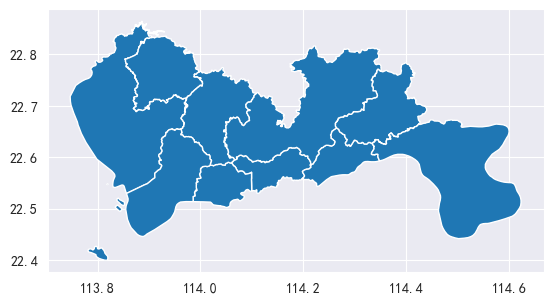

In [35]:
# 读取shp格式地理数据文件，读.shp
sz = gpd.GeoDataFrame.from_file(r'./assets/data/sz/sz.shp', encoding='utf8')
# 绘制地理数据文件
sz.plot()

In [36]:
# 定义研究范围与栅格大学，计算△log与△lat
# 划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748
# 取得左下角的经纬度
latStart = min(lat1, lat2)
lonStart = min(lon1, lon2)
# 定义栅格大小，单位为米
accuracy = 500
# 计算栅格的经纬度增加量大小△Lon和△Lat，地球半径取6371004米
deltaLon = accuracy * 360 / (
        2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360))
deltaLat = accuracy * 360 / (2 * math.pi * 6371004)
# 计算每个栅格的四个顶点坐标，循环生成栅格，生成整个研究范围的栅格
# 定义空的GeoDataFrame表，再往里加栅格
data = gpd.GeoDataFrame()
# 定义空的list，后面循环一次就往里面加东西
LONCOL_list = []
LATCOL_list = []
geometry_list = []
HBLON_list = []
HBLAT_list = []
# 计算行列要生成的栅格数量
# lon方向是lonsnum个栅格
lonsnum = int((lon2 - lon1) / deltaLon) + 1
# lat方向是latsnum个栅格
latsnum = int((lat2 - lat1) / deltaLat) + 1
for i in range(lonsnum):
    for j in range(latsnum):
        #第i列，第j行的栅格中心点坐标
        HBLON = i * deltaLon + lonStart
        HBLAT = j * deltaLat + latStart
        #用周围的栅格推算三个顶点的位置
        HBLON_1 = (i + 1) * deltaLon + lonStart
        HBLAT_1 = (j + 1) * deltaLat + latStart
        #生成栅格的Polygon形状
        grid_ij = Polygon([
            (HBLON - deltaLon / 2, HBLAT - deltaLat / 2),
            (HBLON_1 - deltaLon / 2, HBLAT - deltaLat / 2),
            (HBLON_1 - deltaLon / 2, HBLAT_1 - deltaLat / 2),
            (HBLON - deltaLon / 2, HBLAT_1 - deltaLat / 2)])
        #把生成的数据都加入到前面定义的空list里面
        LONCOL_list.append(i)
        LATCOL_list.append(j)
        HBLON_list.append(HBLON)
        HBLAT_list.append(HBLAT)
        geometry_list.append(grid_ij)
# 为geopandas文件的每一列赋值为刚刚的list
data['LONCOL'] = LONCOL_list
data['LATCOL'] = LATCOL_list
data['HBLON'] = HBLON_list
data['HBLAT'] = HBLAT_list
data['geometry'] = geometry_list
data

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,0,113.751940,22.447837,"POLYGON ((113.74950 22.44559, 113.75438 22.445..."
1,0,1,113.751940,22.452334,"POLYGON ((113.74950 22.45009, 113.75438 22.450..."
2,0,2,113.751940,22.456830,"POLYGON ((113.74950 22.45458, 113.75438 22.454..."
3,0,3,113.751940,22.461327,"POLYGON ((113.74950 22.45908, 113.75438 22.459..."
4,0,4,113.751940,22.465823,"POLYGON ((113.74950 22.46358, 113.75438 22.463..."
...,...,...,...,...,...
16735,179,88,114.624138,22.843538,"POLYGON ((114.62170 22.84129, 114.62657 22.841..."
16736,179,89,114.624138,22.848035,"POLYGON ((114.62170 22.84579, 114.62657 22.845..."
16737,179,90,114.624138,22.852531,"POLYGON ((114.62170 22.85028, 114.62657 22.850..."
16738,179,91,114.624138,22.857028,"POLYGON ((114.62170 22.85478, 114.62657 22.854..."


<Axes: >

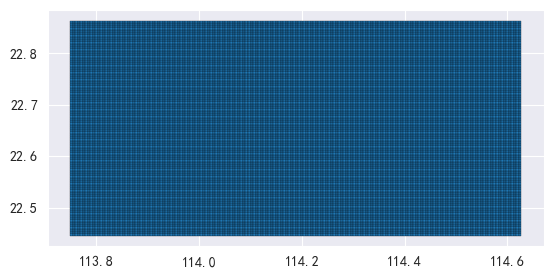

In [37]:
# 绘制所创建栅格的空间分布
data.plot(edgecolor=(0, 0, 0, 1), linewidth=0.2)

<Axes: >

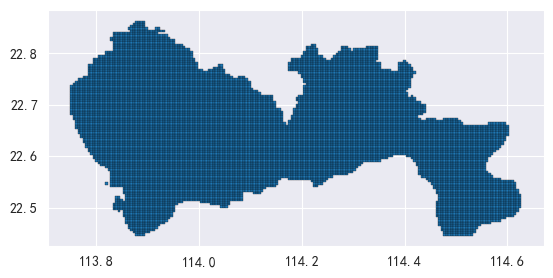

In [38]:
# 将前面读取的GeoDataFrame用unary_union方法合并为一个Polygon图形作为研究范围
roi = sz.unary_union
# 输入行政区划的Polygon，利用GeoDataFrame的intersects方法，筛选出研究范围的栅格，将行政区划外的栅格剔除
grid_sz = data[data.intersects(roi)]
grid_sz.plot(edgecolor=(0, 0, 0, 1), linewidth=0.2)

In [39]:
# 将数据保存到本地
grid_sz.to_file(r'./assets/data/grid_sz.json', driver='GeoJSON')

##### 2.3.1.2 GPS数据的栅格对应与统计

GPS数据以经纬度坐标的形式记录，计算每个GPS点对应的栅格编号，然后基于栅格编号统计每个栅格内GPS数据量。

In [40]:
# 读取数据
data = pd.read_csv('./assets/data/TaxiData-Sample.csv', header=None)
data.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']
# 数据对应的栅格经纬度编号
data['LONCOL'] = ((data['Lng'] - (lonStart - deltaLon / 2)) / deltaLon).astype(
    'int')
data['LATCOL'] = ((data['Lat'] - (latStart - deltaLat / 2)) / deltaLat).astype(
    'int')
# 集计栅格数据量
data_distribution = data.groupby(['LONCOL', 'LATCOL'])[
    'VehicleNum'].count().rename('count').reset_index()
# 剔除不在研究范围内的OD记录
data_distribution = data_distribution[
    (data_distribution['LONCOL'] >= 0) & (data_distribution['LATCOL'] >= 0) &
    (data_distribution['LONCOL'] <= lonsnum) & (
            data_distribution['LATCOL'] <= latsnum)]
data_distribution

,LONCOL,LATCOL,count
188,0,77,1
189,0,78,7
190,0,81,4
192,1,77,3
193,1,78,1
...,...,...,...
3968,160,89,2
3969,162,91,2
3970,163,92,1
3971,164,93,2


##### 2.3.1.3 统计结果与栅格连接

前面已经完成了栅格数据量的统计，其中的 `LONCOL` 与 `LATCOL` 列标识了栅格编号， `count` 则为数据量统计。接下来需要把统计出的结果连接到栅格的空间地理信息 `grid_sz` 表上，也就是执行表的连接。

在对 `DataFrame` 和 `GeoDataFrame` 表连接的时候需要特别注意， `merge` 函数保留传入的第一个对象的数据形式，如果想要让连接后的表格保持 `GeoDataFrame` 的形式，则必须将地理信息表放在前面。

In [41]:
# 将栅格数据与统计数据进行表连接，在栅格数据上加上数据量
grid_count = pd.merge(grid_sz, data_distribution, on=['LONCOL', 'LATCOL'])
# 保存数据
grid_count.to_file(r'./assets/data/grid_count.json', driver='GeoJSON')
grid_count

,LONCOL,LATCOL,HBLON,HBLAT,geometry,count
0,5,52,113.776303,22.681660,"POLYGON ((113.77387 22.67941, 113.77874 22.679...",6
1,5,53,113.776303,22.686157,"POLYGON ((113.77387 22.68391, 113.77874 22.683...",3
2,5,54,113.776303,22.690654,"POLYGON ((113.77387 22.68841, 113.77874 22.688...",1
3,5,55,113.776303,22.695150,"POLYGON ((113.77387 22.69290, 113.77874 22.692...",1
4,5,56,113.776303,22.699647,"POLYGON ((113.77387 22.69740, 113.77874 22.697...",6
...,...,...,...,...,...,...
3397,151,33,114.487705,22.596225,"POLYGON ((114.48527 22.59398, 114.49014 22.593...",2
3398,152,33,114.492577,22.596225,"POLYGON ((114.49014 22.59398, 114.49501 22.593...",1
3399,153,34,114.497450,22.600722,"POLYGON ((114.49501 22.59847, 114.49989 22.598...",2
3400,154,33,114.502323,22.596225,"POLYGON ((114.49989 22.59398, 114.50476 22.593...",1


##### 2.3.1.4 栅格数据分布可视化

接下来绘制栅格数据分布，并将 `count` 一列映射给颜色，此时 `grid_count` 变量已为 `GeoDataFrame` 格式，可以直接应用 `plot` 函数进行绘制，并指定栅格颜色随 `count` 列数值变化（即颜色映射），栅格的边界设置为 `0` 时，绘制出的效果即类似像素画。

从数据的栅格分布上看，数据集中分布于中心城区，郊区存在大片空白没数据的地方，这部分地方没有出租车需求。郊区有数据的地方则明显呈现线型分布，与道路的分布相对应。

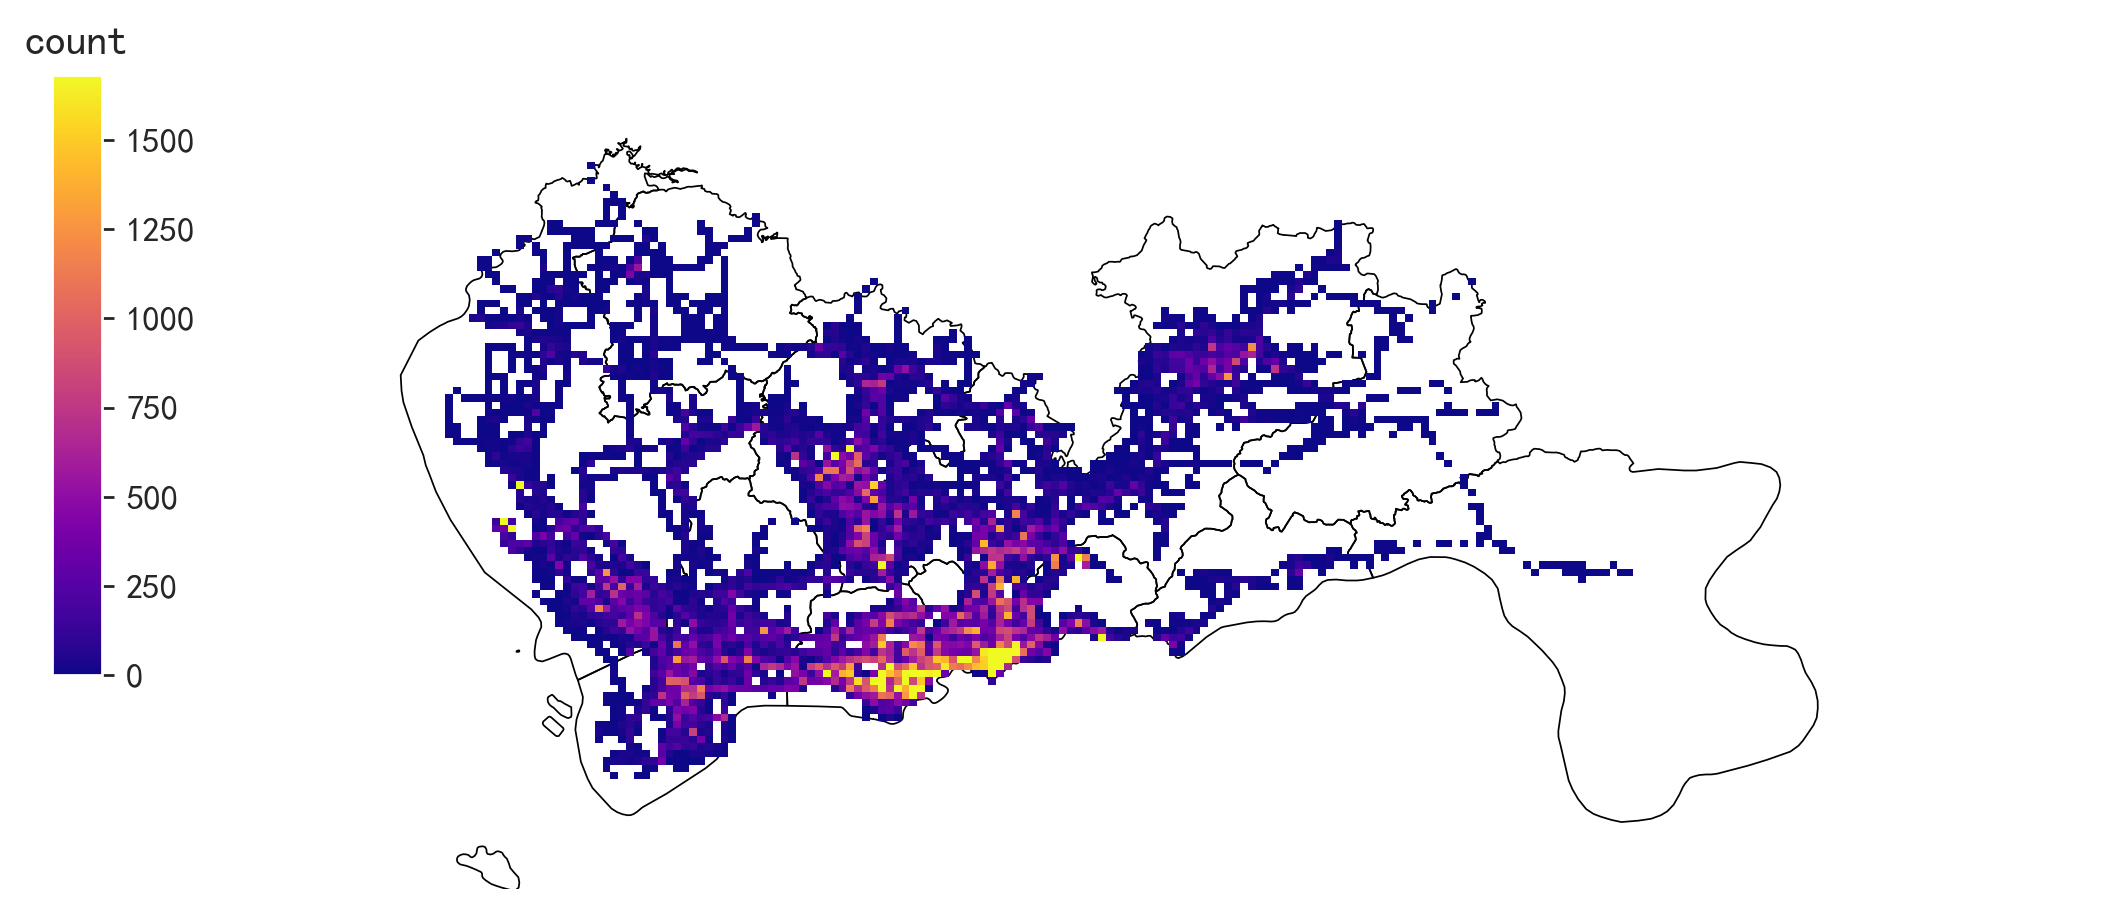

In [42]:
# 绘制
fig = plt.figure(1, (10, 8), dpi=250)
ax = plt.subplot(111)
# 绘制行政区划的边界
sz.plot(ax=ax, edgecolor=(0, 0, 0, 1), facecolor=(0, 0, 0, 0), linewidths=0.5)
# 设置colormap与colorbar
# 设置99%分位数为colorbar最大值
vmax = grid_count['count'].quantile(0.99)
# 换一种内置颜色
cmapname = 'plasma'
cmap = mpl.colormaps.get_cmap(cmapname)
# 创建colorbar的纸，命名为cax
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
# 此时因为创建了新的纸，plt移动到了cax这张纸上，设定colorbar的标题
plt.title('count')
# plt移动回ax这张纸上
plt.sca(ax)
# 绘制栅格
grid_count.plot(ax=ax, column='count', linewidth=0,
                vmin=0, vmax=vmax, cmap=cmap,
                legend=True, cax=cax)
plt.axis('off')
plt.xlim(113.6, 114.8)
plt.ylim(22.4, 22.9)
plt.show()

#### 2.3.2 出租车GPS数据空间分布散点图

In [43]:
# 经纬度小数点保留三位小数简便计算
data2 = data[['Lng', 'Lat']].round(3).copy()
# 统计每个小范围内数据量
data2['count'] = 1
data2 = data2.groupby(['Lng', 'Lat'])['count'].count().reset_index()
# 排序数据，让数据量小的放上面先画，数据大的放下面最后画
data2 = data2.sort_values(by='count')
data2

,Lng,Lat,count
0,108.002,10.280,1
19906,114.123,22.640,1
19911,114.123,22.665,1
5439,113.913,22.483,1
5438,113.912,22.906,1
...,...,...,...
22188,114.180,22.556,1466
11185,114.013,22.668,1495
912,113.819,22.650,1558
10735,114.008,22.535,1916


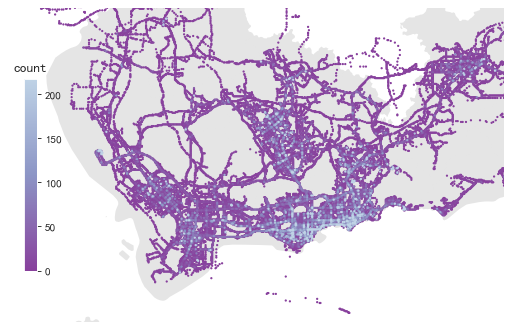

In [44]:
# 将统计的GPS点以散点图的形式绘制
# 创建图框
fig = plt.figure(1, (8, 8), dpi=80)
ax = plt.subplot(111)
plt.sca(ax)
# 绘制行政区划的边界
bounds = [113.7, 22.42, 114.3, 22.8]
sz.plot(ax=ax, edgecolor=(0, 0, 0, 0), facecolor=(0, 0, 0, 0.1), linewidths=0.5)
# 定义colorbar
pallete_name = "BuPu"
colors = sns.color_palette(pallete_name, 3)
colors.reverse()
cmap = mpl.colors.LinearSegmentedColormap.from_list(pallete_name, colors)
vmax = data2['count'].quantile(0.99)
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
# 绘制散点图
plt.scatter(data2['Lng'], data2['Lat'], s=1, alpha=1, c=data2['count'],
            cmap=cmap, norm=norm)
plt.axis('off')
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])
# 绘制colorbar
cax = plt.axes([0.15, 0.33, 0.02, 0.3])
plt.colorbar(cax=cax)
plt.title('count')
plt.show()

#### 2.3.3 出租车GPS数据空间分布热力图

对于数据的空间分布，还可以采用热力图进行绘制。在 `Matplotlib` 中绘制热力图则有两种方式，一种是采用等高线图直接对数据的分布进行绘制，另一种则是用二维核密度绘制。下面分别使用这两种方法进行绘制。

##### 2.3.3.1 出租车GPS数据空间分布等高线图

`plt.contour` （只绘制等高线）与 `plt.contourf` （绘制等高线且在等高线之间填充颜色）是 `Matplotlib` 提供的等高线绘制方法，绘制出来的颜色代表的值代表数据量密度，具有现实物理意义。

用这种方式绘制对数据要求较高，需要数据分布本身就比较平滑，否则可视化效果不佳。 `plt.contourf` 需要将数据整理为矩阵形式。其中 `x` 为经度 `y` 为纬度，均为一维向量；而 `z=matrix[x][y]` 则为二维矩阵，内容是数据量。所以在绘制之前需要将数据转换成指定的形式输入。同时，也可以通过 `levels` 参数自行指定等高线绘制的层数与等高线的值。

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_14056\1696111523.py:4: RuntimeWarning: divide by zero encountered in log
  z = np.log(d.values)


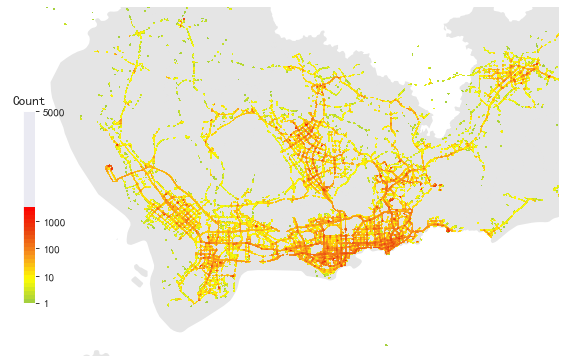

In [45]:
# 转换数据透视表，变成矩阵格式
d = data2.pivot(columns='Lng', index='Lat', values='count').fillna(0)
# 取对数，缩小最大最小值之间的差距
z = np.log(d.values)
x = d.columns
y = d.index
# 划分层数
levels = np.linspace(0, z.max(), 25)
fig = plt.figure(1, (8, 8), dpi=80)
ax = plt.subplot(111)
plt.sca(ax)
# 调整整体空白
fig.tight_layout(rect=(0.05, 0.1, 1, 0.9))
# 绘制行政区划的边界
bounds = [113.7, 22.42, 114.3, 22.8]
sz.plot(ax=ax, edgecolor=(0, 0, 0, 0), facecolor=(0, 0, 0, 0.1), linewidths=0.5)
# 定义colorbar
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap',
                                                    ['#9DCC42', '#FFFE03',
                                                     '#F7941D', '#E9420E',
                                                     '#FF0000'],
                                                    256)
# 绘制等高线图
plt.contourf(x, y, z, levels=levels, cmap=cmap, origin='lower')
plt.axis('off')
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])
# 绘制colorbar
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
cbar = plt.colorbar(cax=cax)
# 调整colorbar的显示标记位置
val = [1, 10, 100, 1000, 5000]
pos = np.log(np.array(val))
# 在什么位置显示标记
cbar.set_ticks(pos)
# 标记显示什么内容
cbar.set_ticklabels(val)
plt.title('Count')
plt.show()

##### 2.3.3.2 出租车GPS数据空间二维核密度分布图

另一种方法是用核密度，用 `seaborn` 的 `kdeplot` 进行二维核密度分布的绘制。这一方法的原理是赋予每一个点数据一定的影响范围，利用离散的数据估计连续概率密度，将数据的分布进行平滑处理。经过处理后，估计出来的是抽象的密度值，无法对应现实的物理意义。

C:\Users\GGG\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


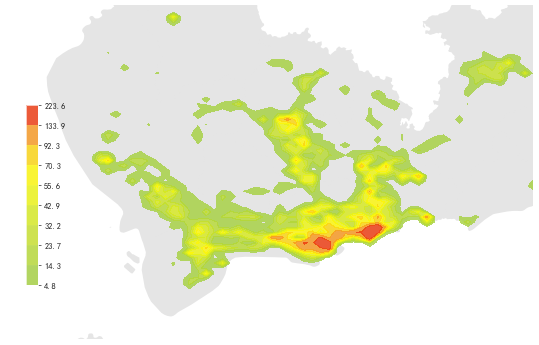

In [46]:
fig = plt.figure(1, (10, 10), dpi=60)
ax = plt.subplot(111)
plt.sca(ax)
# 调整整体空白
fig.tight_layout(rect=(0.05, 0.1, 1, 0.9))
# 绘制行政区划的边界
bounds = [113.7, 22.42, 114.3, 22.8]
sz.plot(ax=ax, edgecolor=(0, 0, 0, 0), facecolor=(0, 0, 0, 0.1), linewidths=0.5)
# colorbar的数据
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap',
                                                    ['#9DCC42', '#FFFE03',
                                                     '#F7941D', '#E9420E',
                                                     '#FF0000'],
                                                    256)
# 设定位置
plt.axis('off')
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])
# 定义colorbar位置
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
# 绘制二维核密度图
sns.kdeplot('Lng', 'Lat',  # 指定x与y坐标所在的列
            data=data2[data2['count'] > 10],  # 传入数据，筛选去除太小的值
            weights='count',  # 设定权重所在字段
            alpha=0.8,  # 透明度
            gridsize=120,  # 绘图精细度，越高越慢
            bw_method=0.03,  # 高斯核大小（经纬度），越小越精细
            cmap=cmap,  # 定义colormap
            ax=ax,  # 指定绘图位置
            shade=True,  # 等高线间是否填充颜色
            thresh=0.05,  # 最底层不显示颜色
            cbar=True,  # 显示colorbar
            cbar_ax=cax  # 指定colorbar位置
            )
plt.show()

## 3 出租车订单出行特征分析

### 3.1 出租车出行订单OD提取

拿到出租车GPS数据时，我们最关心的核心内容是如何从数据中识别出租车的出行，包括每一趟出租车出行的车辆、起点（O点）、终点（D点）、开始时间、结束时间的信息。

我们希望将手上的 `DataFrame` （每一行为一个GPS点）整理为一个出行OD信息表（每一行数据代表一次出租车出行，而出行的起点、终点、时间、车牌等信息则以字段的形式存储）。对此我们需要分两步完成：

1. 提取出GPS数据中的出行开始和结束信息。
2. 将同个订单的信息整理到一行中。

对第一步，在前面对载客状态的分析中已经提到如何判别出租车运营的开始与结束。在数据中提取OD信息，实际上就是将每次出行运营的开始与结束时的那两行信息提取出来。这两行信息都有一个明显的特点：它的载客状态相对上一条数据发生了变化。我们可以通过 `shift` 函数将 `OpenStatus` 往下移一行得到 `OpenStatus1` ，再构建新的一列 `StatusChange` 用于表示载客状态是否发生变化，其值是 `OpenStatus` 减去 `OpenStatus1` 。当 `StatusChange` 为 `1` 时，乘客上车，订单开始；当 `StatusChange` 为 `-1` 时，乘客下车，订单结束。这样就能很轻松地提取出行的OD了，筛选条件如下：

1. `StatusChange` 为 `1` 或 `-1` ，分别对应订单的开始和结束。
2. 下一条数据的车牌号与本条数据的车牌号相等。

对第二步，上一步筛选出的数据表，在正常情况下一条出行订单会存在两条记录，一条表示开始，另一条表示结束。如果按照时间排序，则开始与结束交替出现。这一步要做的就是将这两条记录的内容合并为一条记录显示。其原理也非常简单，只需要将表的所有列整体往上移一行后将表拼起来，保留 `StatusChange` 的值为 `1` 的记录即可。

In [47]:
# 提取出行的开始与结束信息
# 读取GPS数据文件
data = pd.read_csv('./assets/data/TaxiData-clean.csv')
# 构建StatusChange列
data['StatusChange'] = data['OpenStatus'] - data['OpenStatus'].shift()
# 筛选出行开始和结束信息
oddata = data[((data['StatusChange'] == -1) |
               (data['StatusChange'] == 1)) &
              (data['VehicleNum'].shift() == data['VehicleNum'])]
# 删去无用的列
oddata = oddata.drop(['OpenStatus', 'Speed'], axis=1)
oddata

,VehicleNum,Stime,Lng,Lat,StatusChange
5,22396,00:03:01,113.994934,22.697884,-1.0
33,22396,00:19:41,114.013016,22.664818,1.0
38,22396,00:23:01,114.021400,22.663918,-1.0
73,22396,00:41:51,114.021767,22.640200,1.0
75,22396,00:43:44,114.026070,22.640266,-1.0
...,...,...,...,...,...
543866,36805,23:20:09,114.133286,22.617750,-1.0
543928,36805,23:36:19,114.112968,22.549601,1.0
543995,36805,23:43:12,114.089485,22.538918,-1.0
544008,36805,23:46:14,114.091217,22.540768,1.0


上表中 `StatusChange` 字段的 `1` 和 `-1` 大部分是成对交替出现的。第一条数据是从订单结束开始，原因是数据的观测时段开始时，这个订单正在运营中。

第二步，数据处理成 `oddata` 的形式，虽然能够从数据中找到订单的OD，但是每个订单有两条数据，我们当然希望一个订单只有一行数据，这行数据能同时包含订单的OD信息、订单开始和结束的时间信息。观察 `oddata` ，很容易就想到了用 `shift` 函数来处理连续数据，但是要注意使用 `shift` 后要保证数据属于同一辆出租车。

In [48]:
# 数据处理成OD表的形式
# 首先给oddata更改列名
oddata.columns = ['VehicleNum', 'Stime', 'SLng', 'SLat', 'StatusChange']
# 把一个订单的两行数据整理成一行
oddata['Etime'] = oddata['Stime'].shift(-1)
oddata['ELng'] = oddata['SLng'].shift(-1)
oddata['ELat'] = oddata['SLat'].shift(-1)
# 筛选正确的订单OD数据：StatusChange == 1；shift后的数据属于同一个出租车
oddata = oddata[(oddata['StatusChange'] == 1) &
                (oddata['VehicleNum'] == oddata['VehicleNum'].shift(-1))]
# 去掉StatusChange列
oddata = oddata.drop('StatusChange', axis=1)
oddata

,VehicleNum,Stime,SLng,SLat,Etime,ELng,ELat
33,22396,00:19:41,114.013016,22.664818,00:23:01,114.021400,22.663918
73,22396,00:41:51,114.021767,22.640200,00:43:44,114.026070,22.640266
78,22396,00:45:44,114.028099,22.645082,00:47:44,114.030380,22.650017
114,22396,01:08:26,114.034897,22.616301,01:16:34,114.035614,22.646717
138,22396,01:26:06,114.046021,22.641251,01:34:48,114.066048,22.636183
...,...,...,...,...,...,...,...
543573,36805,22:49:12,114.114365,22.550632,22:50:40,114.115501,22.557983
543590,36805,22:52:07,114.115402,22.558083,23:03:12,114.118484,22.547867
543702,36805,23:03:45,114.118484,22.547867,23:20:09,114.133286,22.617750
543928,36805,23:36:19,114.112968,22.549601,23:43:12,114.089485,22.538918


### 3.2 出租车出行订单的小时分布

我们可以小时数据量统计同样的方式，统计 `oddata` 数据表，得到出行订单数量的时间分布。出租车订单是一个持续的过程，有开始与结束的时间。这里为了方便计算，以订单的开始时间为准对订单进行小时统计。

从订单的开始时间统计可以看出，出租车订单并没有在某个时间段存在明显缺失。在夜间时段，订单数量有一个明显的低谷，这也与实际的需求相符。从数据量与订单量的时间分布上看，出租车数据在时间分布上是较为完整的。

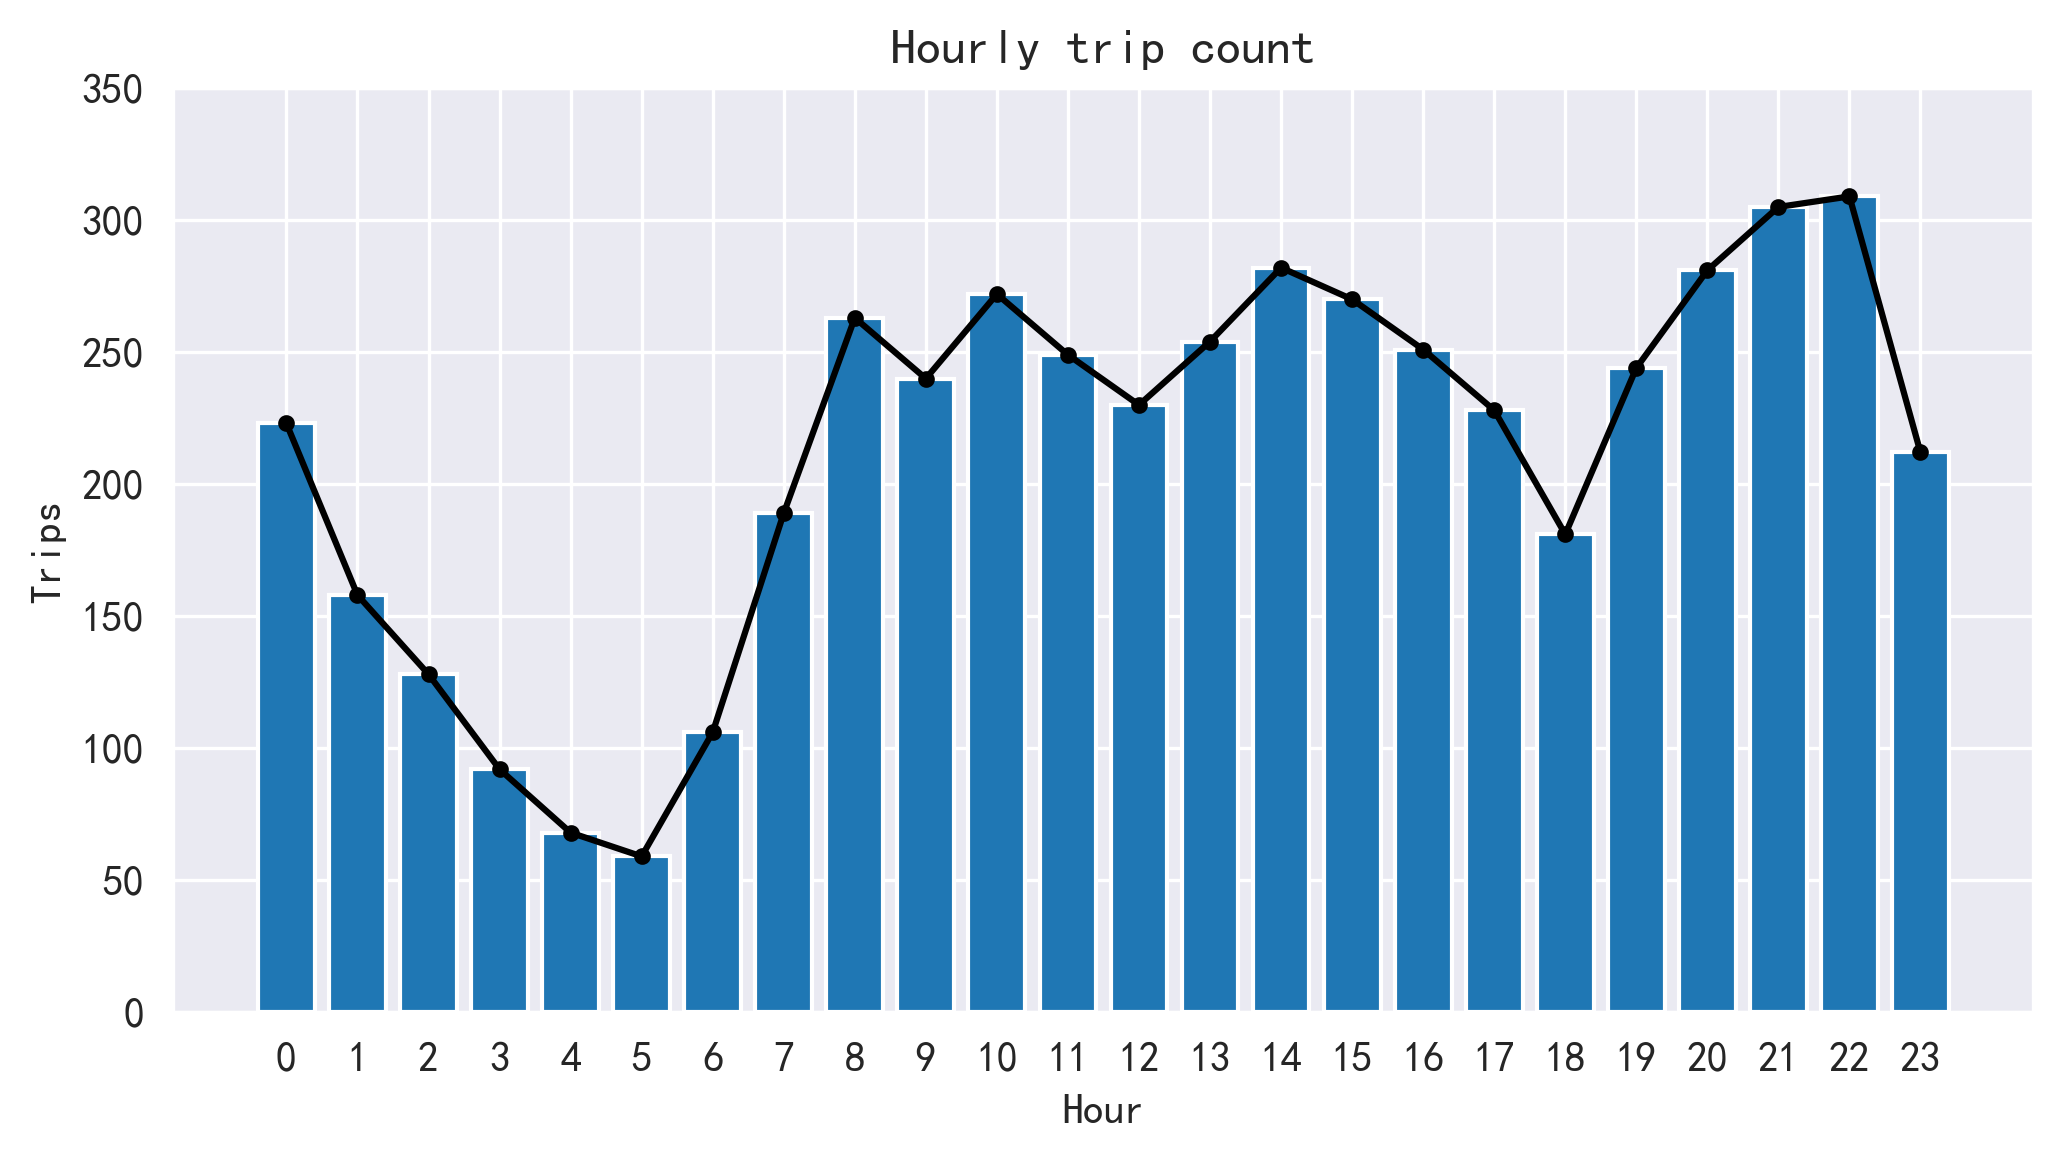

In [49]:
# 统计每小时订单数
oddata['Hour'] = oddata.apply(lambda r: r['Stime'][:2], axis=1).astype(int)
Hourcount_od = oddata.groupby('Hour')['VehicleNum'].count()
Hourcount_od = Hourcount_od.rename('count').reset_index()
# 绘制折线图
fig = plt.figure(1, (8, 4), dpi=300)
ax = plt.subplot(111)
plt.plot(Hourcount_od['Hour'], Hourcount_od['count'], 'k-')
plt.plot(Hourcount_od['Hour'], Hourcount_od['count'], 'k.')
plt.bar(Hourcount_od['Hour'], Hourcount_od['count'])
plt.ylabel('Trips')
plt.xlabel('Hour')
plt.xticks(range(24), range(24))
plt.title('Hourly trip count')
plt.ylim(0, 350)
plt.show()

### 3.3 出租车出行订单持续时间统计

正常的出租车出行，一般从开始到结束的持续时间不会过短，也不会过长，需要在一个合理的范围内。因此从订单的持续时间上，可以进一步分析出租车订单的基本特征以及数据的准确性。

#### 3.3.1 订单持续时间的统计

首先，需要通过订单的开始时间与结束时间计算订单的持续时间，这里介绍两种方法：标准化时间与时间格式转换。

1. **标准化时间**。标准化时间以 `0` 点为初始时间，将某一时刻转换为相对初始时间的时间差。以 `01:30:20` 为例，这一时刻相对于 `0` 点的时间差为 `1 x 3600 + 30 x 60 + 20 = 217820` 秒。将订单的开始与结束时间都转换为相对 `0` 点经过多少秒，则订单的持续时间即为这两者的差值。
2. **时间格式转化**。将字符串数据转换为时间格式的列，经过转换后，数据支持时间差直接运算。因此将 `Stime` 与 `Etime` 转换为时间格式后进行差值运算。

两者结果一样，第一种方法要快一些。

In [50]:
# 标准化时间
# 订单开始时间标准化
oddata['Stime_st'] = oddata['Stime'].apply(
    lambda r: int(r.split(':')[0])) * 3600 + oddata['Stime'].apply(
    lambda r: int(r.split(':')[1])) * 60 + oddata['Stime'].apply(
    lambda r: int(r.split(':')[2]))
# 订单结束时间标准化
oddata['Etime_st'] = oddata['Etime'].apply(
    lambda r: int(r.split(':')[0])) * 3600 + oddata['Etime'].apply(
    lambda r: int(r.split(':')[1])) * 60 + oddata['Etime'].apply(
    lambda r: int(r.split(':')[2]))
# 计算时间差
oddata['duration'] = (oddata['Etime_st'] - oddata['Stime_st'])
oddata

,VehicleNum,Stime,SLng,SLat,Etime,ELng,ELat,Hour,Stime_st,Etime_st,duration
33,22396,00:19:41,114.013016,22.664818,00:23:01,114.021400,22.663918,0,1181,1381,200
73,22396,00:41:51,114.021767,22.640200,00:43:44,114.026070,22.640266,0,2511,2624,113
78,22396,00:45:44,114.028099,22.645082,00:47:44,114.030380,22.650017,0,2744,2864,120
114,22396,01:08:26,114.034897,22.616301,01:16:34,114.035614,22.646717,1,4106,4594,488
138,22396,01:26:06,114.046021,22.641251,01:34:48,114.066048,22.636183,1,5166,5688,522
...,...,...,...,...,...,...,...,...,...,...,...
543573,36805,22:49:12,114.114365,22.550632,22:50:40,114.115501,22.557983,22,82152,82240,88
543590,36805,22:52:07,114.115402,22.558083,23:03:12,114.118484,22.547867,22,82327,82992,665
543702,36805,23:03:45,114.118484,22.547867,23:20:09,114.133286,22.617750,23,83025,84009,984
543928,36805,23:36:19,114.112968,22.549601,23:43:12,114.089485,22.538918,23,84979,85392,413


In [51]:
# 时间格式转换
oddata['duration'] = pd.to_datetime(oddata['Etime']) - pd.to_datetime(
    oddata['Stime'])
# 将时间差转换为秒
oddata['duration'] = oddata['duration'].apply(lambda r: r.seconds)
oddata

,VehicleNum,Stime,SLng,SLat,Etime,ELng,ELat,Hour,Stime_st,Etime_st,duration
33,22396,00:19:41,114.013016,22.664818,00:23:01,114.021400,22.663918,0,1181,1381,200
73,22396,00:41:51,114.021767,22.640200,00:43:44,114.026070,22.640266,0,2511,2624,113
78,22396,00:45:44,114.028099,22.645082,00:47:44,114.030380,22.650017,0,2744,2864,120
114,22396,01:08:26,114.034897,22.616301,01:16:34,114.035614,22.646717,1,4106,4594,488
138,22396,01:26:06,114.046021,22.641251,01:34:48,114.066048,22.636183,1,5166,5688,522
...,...,...,...,...,...,...,...,...,...,...,...
543573,36805,22:49:12,114.114365,22.550632,22:50:40,114.115501,22.557983,22,82152,82240,88
543590,36805,22:52:07,114.115402,22.558083,23:03:12,114.118484,22.547867,22,82327,82992,665
543702,36805,23:03:45,114.118484,22.547867,23:20:09,114.133286,22.617750,23,83025,84009,984
543928,36805,23:36:19,114.112968,22.549601,23:43:12,114.089485,22.538918,23,84979,85392,413


#### 3.3.2 订单持续时间的箱型图绘制

接下来，依据订单的开始时间对订单持续时间的分布绘制多分类的箱形图。箱形图的绘制有两种方法：`Matlotlib` 的 `boxplot` 和 `seaborn` 库的 `boxplot` 。

使用 `Matlotlib` 的 `boxplot` 函数进行绘制，需要对数据进行整理，将每一种分类的数据单独作为一列放入一个列表中，再传入 `plt.boxplot` 函数中。而对同样的图 `seaborn` 库中的 `boxplot` 函数在绘图的基础上加入了数据处理的步骤，免去了数据整理的部分。

接下来使用两种方法分别进行绘制。从结果可以看出，出租车的订单持续时间在一日之中的不同时间段内存在一定差异，在早晚高峰时间，订单的持续时间明显更长。其原因也很好解释，高峰时间城市道路更加拥挤，出行所需的时间当然就更长了。

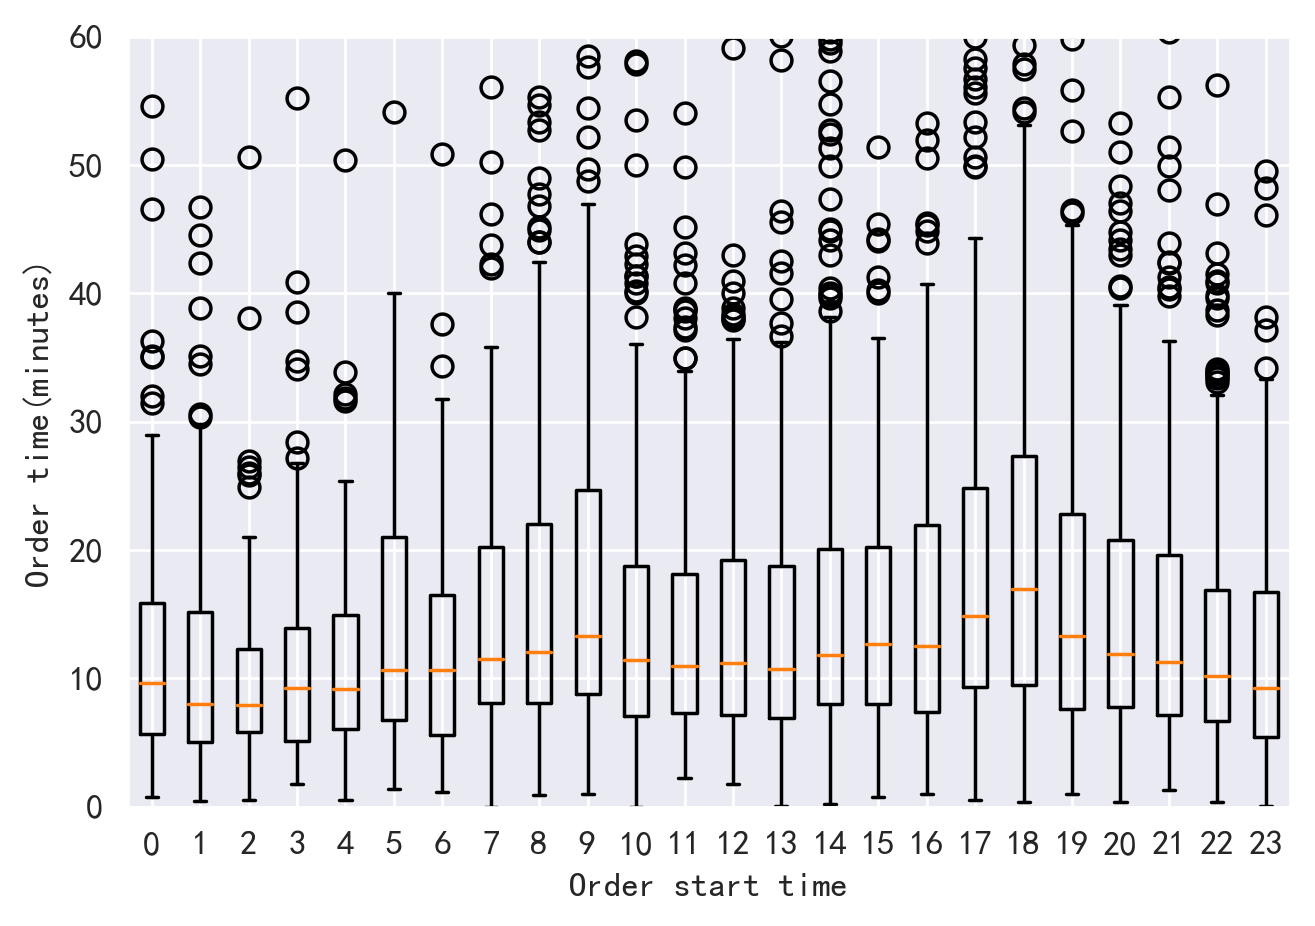

In [52]:
# 订单持续时间箱型图的绘制：plt.boxplot
fig = plt.figure(1, (6, 4), dpi=250)
ax = plt.subplot(111)
plt.sca(ax)
# 整理箱型图的数据，循环遍历每个小时，将列数据放入datas变量中
datas = []
for hour in range(24):
    datas.append(oddata[oddata['Hour'] == hour]['duration'] / 60)
# 绘制箱型图
plt.boxplot(datas)
# 更改x轴ticks的文字,传入两个参数，第一个为位置，第二个为标注文字
plt.xticks(range(1, 25), range(24))
plt.ylabel('Order time(minutes)')
plt.xlabel('Order start time')
plt.ylim(0, 60)
plt.show()

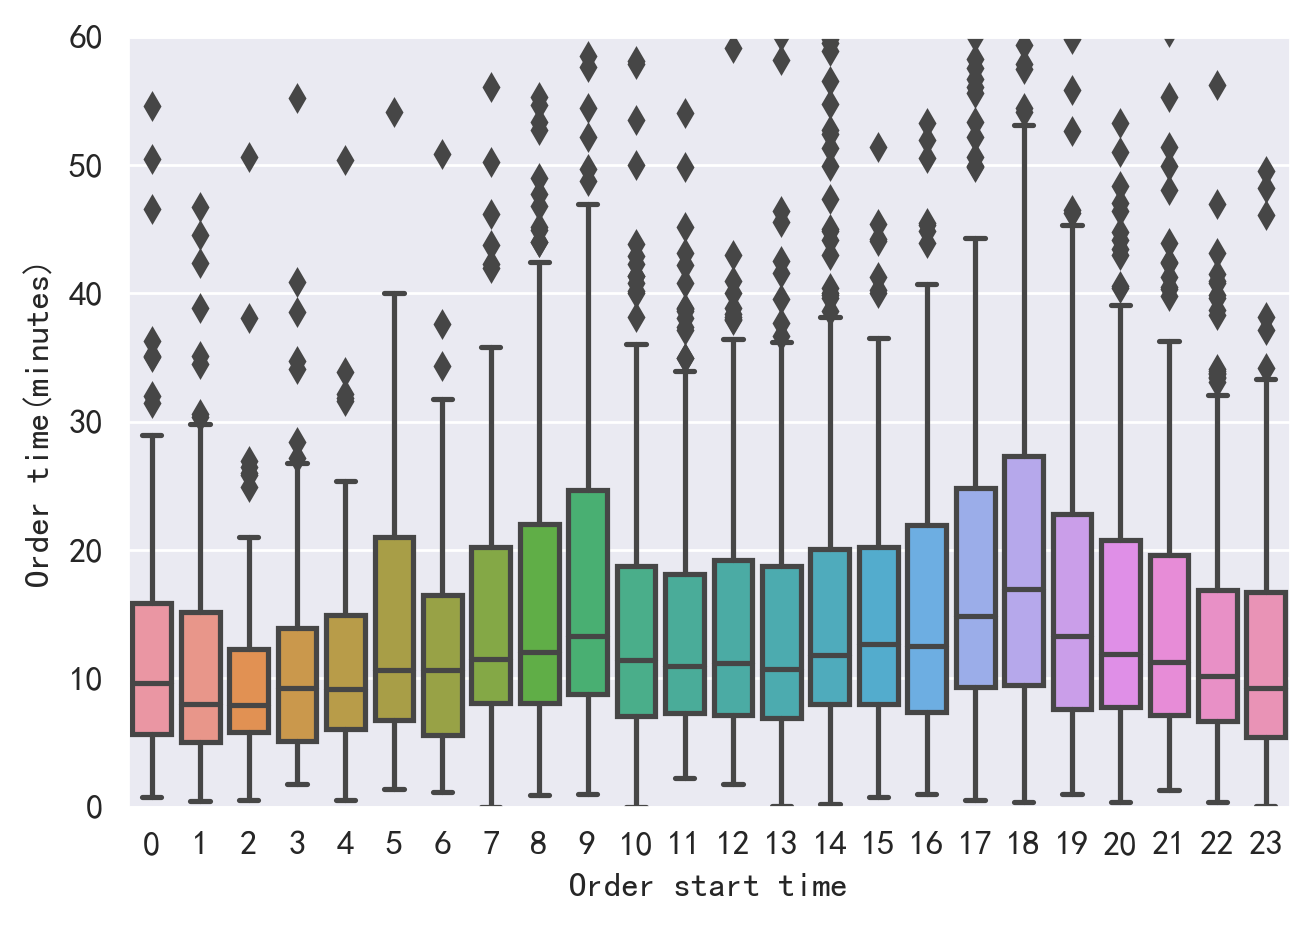

In [53]:
# 订单持续时间箱型图的绘制：sns.boxplot
fig = plt.figure(1, (6, 4), dpi=250)
ax = plt.subplot(111)
plt.sca(ax)
# 只需要一行，指定传入的数据，x轴y轴分别是哪个维度
sns.boxplot(x="Hour", y=oddata["duration"] / 60, data=oddata, ax=ax)
plt.ylabel('Order time(minutes)')
plt.xlabel('Order start time')
plt.ylim(0, 60)
plt.show()

### 3.4 出租车出行订单的栅格OD可视化

### 3.5 出租车出行的OD期望线绘制